<a href="https://colab.research.google.com/github/Kussil/Financial_Sentiment_LLM/blob/main/04_Stock_Modeling/Aggregated_Stock_Data/Llama_Prompt/Source_Testing/Stock_Modeling_LLama_prompt_EarningsCalls.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Stock Modeling using Llama outputs with Prompt 2: Earnings Calls Only


In [1]:
#install dependencies
!pip install -q ipympl

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 516.3/516.3 kB 20.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 58.0 MB/s eta 0:00:00


In [2]:
# import libraries
import os
from google.colab import userdata
from google.colab import output
import pandas as pd
import yfinance as yf
import textwrap
import matplotlib
import matplotlib.pyplot as plt
from datetime import datetime
import pytz
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import mean_squared_error, accuracy_score, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
output.enable_custom_widget_manager()

In [15]:
#Delete repo clone if needed
!rm -rf /content/CVX_Rice_project/

In [16]:
# Import github token with google secrets thingy and clone git repository
GITHUB_TOKEN = userdata.get('github')
os.environ['GITHUB_TOKEN'] = GITHUB_TOKEN
!git clone https://{GITHUB_TOKEN}@github.com/Kussil/Financial_Sentiment_LLM.git

fatal: destination path 'Financial_Sentiment_LLM' already exists and is not an empty directory.


In [5]:
# Read in outputs from Gemini Sentiment Analysis
Llama_sentiment = pd.read_csv('/content/Financial_Sentiment_LLM/03_Sentiment_Analysis/LLama/Llama_data_for_stock_modeling.csv')
Llama_sentiment = Llama_sentiment.fillna('')
Llama_sentiment

,Source,Unique_ID,Ticker,Date,URL,Finance,Production,Reserves/M&A,Regulatory,Green Energy,OG Price
0,Investment Research,IR-1,MRO,2024-05-16,,Neutral,Positive,Neutral,Neutral,Neutral,Neutral
1,Investment Research,IR-2,EOG,2024-05-14,,Positive,Neutral,Neutral,Neutral,Negative,Neutral
2,Investment Research,IR-3,EOG,2024-05-11,,Positive,Neutral,Positive,Negative,Neutral,Positive
3,Investment Research,IR-4,DVN,2024-05-11,,Neutral,Negative,Neutral,Neutral,Negative,Negative
4,Investment Research,IR-5,COP,2024-05-07,,Neutral,Positive,Neutral,Negative,Neutral,Positive
...,...,...,...,...,...,...,...,...,...,...,...
10120,Earnings Call Q&A,EQ-338,XOM,2021-02-02,,Neutral,Positive,Neutral,Neutral,Positive,Neutral
10121,Earnings Call Q&A,EQ-339,COP,2021-02-02,,Negative,Negative,Negative,Negative,Negative,Negative
10122,Earnings Call Q&A,EQ-340,EOG,2019-05-03,,Neutral,Positive,Positive,Neutral,Neutral,Neutral
10123,Earnings Call Q&A,EQ-341,SHEL,2019-05-02,,Negative,Negative,Negative,Negative,Negative,Negative


In [20]:
# Define the values to be removed
values_to_remove = ['Other', 'Error']
sentiment_columns = ['Finance', 'Production', 'Reserves/M&A', 'Regulatory', 'Green Energy', 'OG Price']
# Filter out rows with these values in any sentiment column
Llama_sentiment = Llama_sentiment[~Llama_sentiment.isin(values_to_remove).any(axis=1)]

# Printing out unique sentiment variables per each category for QC
for column in sentiment_columns:
    print(f"\nUnique values in {column}:")
    unique_values = Llama_sentiment[column].unique()
    print(unique_values)
    print(f"Total unique values in {column}: {len(unique_values)}")



Unique values in Finance:
[ 0  1 -1]
Total unique values in Finance: 3

Unique values in Production:
[ 1  0 -1]
Total unique values in Production: 3

Unique values in Reserves/M&A:
[0 1 -1]
Total unique values in Reserves/M&A: 3

Unique values in Regulatory:
[ 0  1 -1]
Total unique values in Regulatory: 3

Unique values in Green Energy:
[0 1 -1]
Total unique values in Green Energy: 3

Unique values in OG Price:
[ 0  1 -1]
Total unique values in OG Price: 3


In [6]:
source_values = Llama_sentiment["Source"].unique()
source_values


array(['Investment Research', 'ProQuest', 'SEC Filings',
       'Earnings Call Presentations', 'Earnings Call Q&A'], dtype=object)

In [7]:
# Define a list of date formats
date_formats = [
    '%d/%m/%Y',  # 01/01/2021
    '%m/%d/%Y',  # 5/16/2024
    '%Y-%m-%d',  # 2021-02-28
    '%B %d, %Y',  # March 15, 2021
    '%b-%d-%Y',  # Apr-30-2019
    '%Y.%m.%d',  # 2021.04.10
    '%m-%d-%Y',  # 04-10-2021
    '%d-%b-%y',  # 17-Aug-22
    '%b-%y'  # Sep-19
]

# Function to parse dates with multiple formats
def parse_date(date_str):
    for fmt in date_formats:
        try:
            # Handle special case where only month and year are given
            if fmt == '%b-%y':
                parsed_date = datetime.strptime(date_str, fmt)
                # Default to the first day of the month
                return parsed_date.replace(day=1)
            return datetime.strptime(date_str, fmt)
        except ValueError:
            continue
    raise ValueError(f"Date format not recognized: {date_str}")

# Apply the function to the 'Date' column
Llama_sentiment['Date'] = Llama_sentiment['Date'].apply(parse_date)

# Format the dates in a specific string format
Llama_sentiment['Date'] = Llama_sentiment['Date'].dt.strftime('%Y-%m-%d')

# Modifying the original dataframe to only include rows where the source is "Earnings Call Presentations" or "Earnings Call Q&A"
Llama_sentiment = Llama_sentiment[Llama_sentiment["Source"].isin(["Earnings Call Presentations", "Earnings Call Q&A"])]

# Display the DataFrame
Llama_sentiment

,Source,Unique_ID,Ticker,Date,URL,Finance,Production,Reserves/M&A,Regulatory,Green Energy,OG Price
9618,Earnings Call Presentations,EP-1,CVX,2024-04-26,,Neutral,Positive,Neutral,Neutral,Neutral,Neutral
9619,Earnings Call Presentations,EP-2,CVX,2024-02-02,,Positive,Positive,Neutral,Neutral,Positive,Neutral
9620,Earnings Call Presentations,EP-3,CVX,2023-10-27,,Neutral,Positive,Neutral,Positive,Positive,Neutral
9621,Earnings Call Presentations,EP-4,CVX,2023-07-28,,Positive,Neutral,Positive,Neutral,Neutral,Neutral
9622,Earnings Call Presentations,EP-5,CVX,2023-04-28,,Positive,Neutral,Neutral,Neutral,Neutral,Neutral
...,...,...,...,...,...,...,...,...,...,...,...
10120,Earnings Call Q&A,EQ-338,XOM,2021-02-02,,Neutral,Positive,Neutral,Neutral,Positive,Neutral
10121,Earnings Call Q&A,EQ-339,COP,2021-02-02,,Negative,Negative,Negative,Negative,Negative,Negative
10122,Earnings Call Q&A,EQ-340,EOG,2019-05-03,,Neutral,Positive,Positive,Neutral,Neutral,Neutral
10123,Earnings Call Q&A,EQ-341,SHEL,2019-05-02,,Negative,Negative,Negative,Negative,Negative,Negative


In [9]:
#Create Positive and Negative Ratios for each row

# Columns to consider for calculating ratios
columns_to_check = ['Finance', 'Production', 'Reserves/M&A', 'Regulatory', 'Green Energy', 'OG Price']

# Function to calculate positive and negative ratios
def calculate_ratios(row):
    positive_count = (row[columns_to_check] == 'Positive').sum()
    negative_count = (row[columns_to_check] == 'Negative').sum()
    neutral_count = (row[columns_to_check] == 'Neutral').sum()
    total_count = len(columns_to_check)
    pos_ratio = positive_count / total_count
    neg_ratio = negative_count / total_count
    neu_ratio = neutral_count / total_count
    return pd.Series([pos_ratio, neg_ratio, neu_ratio], index=['Pos_Ratio', 'Neg_Ratio', 'Neu_Ratio'])

# Apply the function to each row
Llama_sentiment[['Pos_Ratio', 'Neg_Ratio', 'Neu_Ratio']] = Llama_sentiment.apply(calculate_ratios, axis=1)

# Replace senitment category values with binary equivalents
binary_mapping = {'Positive': 1, 'Negative': -1, 'Neutral': 0}
Llama_sentiment[columns_to_check] = Llama_sentiment[columns_to_check].replace(binary_mapping)

Llama_sentiment

<ipython-input-9-c753d630a060>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Llama_sentiment[['Pos_Ratio', 'Neg_Ratio', 'Neu_Ratio']] = Llama_sentiment.apply(calculate_ratios, axis=1)
<ipython-input-9-c753d630a060>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Llama_sentiment[['Pos_Ratio', 'Neg_Ratio', 'Neu_Ratio']] = Llama_sentiment.apply(calculate_ratios, axis=1)
<ipython-input-9-c753d630a060>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using

,Source,Unique_ID,Ticker,Date,URL,Finance,Production,Reserves/M&A,Regulatory,Green Energy,OG Price,Pos_Ratio,Neg_Ratio,Neu_Ratio
9618,Earnings Call Presentations,EP-1,CVX,2024-04-26,,0,1,0,0,0,0,0.166667,0.0,0.833333
9619,Earnings Call Presentations,EP-2,CVX,2024-02-02,,1,1,0,0,1,0,0.500000,0.0,0.500000
9620,Earnings Call Presentations,EP-3,CVX,2023-10-27,,0,1,0,1,1,0,0.500000,0.0,0.500000
9621,Earnings Call Presentations,EP-4,CVX,2023-07-28,,1,0,1,0,0,0,0.333333,0.0,0.666667
9622,Earnings Call Presentations,EP-5,CVX,2023-04-28,,1,0,0,0,0,0,0.166667,0.0,0.833333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10120,Earnings Call Q&A,EQ-338,XOM,2021-02-02,,0,1,0,0,1,0,0.333333,0.0,0.666667
10121,Earnings Call Q&A,EQ-339,COP,2021-02-02,,-1,-1,-1,-1,-1,-1,0.000000,1.0,0.000000
10122,Earnings Call Q&A,EQ-340,EOG,2019-05-03,,0,1,1,0,0,0,0.333333,0.0,0.666667
10123,Earnings Call Q&A,EQ-341,SHEL,2019-05-02,,-1,-1,-1,-1,-1,-1,0.000000,1.0,0.000000


In [10]:
#Identify minimum article date for stock price download
min_date = Llama_sentiment['Date'].min()
min_date

'2019-01-30'

In [11]:
ticker_list = Llama_sentiment['Ticker'].unique().tolist()
ticker_list

['CVX',
 'HES',
 'VLO',
 'MPC',
 'PSX',
 'OXY',
 'MRO',
 'DVN',
 'SHEL',
 'COP',
 'XOM',
 'EOG',
 'TTE',
 'BP']

In [12]:
#Pull YahooFinance stock data to get Returns (ret)
all_data = {}

for ticker in ticker_list:
    try:
        # Get the last date for the current ticker from gemini_prompt1_sentiment
        last_date = Llama_sentiment[Llama_sentiment['Ticker'] == ticker]['Date'].max()
        if pd.isna(last_date):
            print(f"No data available for {ticker} in gemini_prompt1_sentiment.")
            continue

        # Ensure the date is in the correct format
        last_date = pd.to_datetime(last_date).strftime('%Y-%m-%d')
        print(f"Downloading data for {ticker} from {min_date} to {last_date}")

        # Download stock data
        data = yf.download(ticker, start=min_date, end=last_date)["Adj Close"]

        if data.empty:
            print(f"No data retrieved for {ticker}")
        else:
            all_data[ticker] = data

    except Exception as e:
        print(f"Error downloading data for {ticker}: {e}")

# Combine all data into a single DataFrame
if all_data:
    price_df = pd.DataFrame(all_data)
    ret_df = price_df.pct_change().dropna()
    ret_df.name = "ret"
    ret_df.describe()
else:
    print("No data available.")

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


[*********************100%%**********************]  1 of 1 completed


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


[*********************100%%**********************]  1 of 1 completed


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


[*********************100%%**********************]  1 of 1 completed


[*********************100%%**********************]  1 of 1 completed


In [13]:
ret_df.describe()

,CVX,HES,VLO,MPC,PSX,OXY,MRO,DVN,SHEL,COP,XOM,EOG,TTE,BP
count,1318.000000,1318.000000,1318.000000,1318.000000,1318.000000,1318.000000,1318.000000,1318.000000,1318.000000,1318.000000,1318.000000,1318.000000,1318.000000,1318.000000
mean,0.000707,0.001281,0.000900,0.001090,0.000605,0.000773,0.001082,0.001362,0.000282,0.000936,0.000657,0.000777,0.000379,0.000253
std,0.021949,0.030217,0.029288,0.028809,0.025606,0.038520,0.035961,0.036340,0.021735,0.025911,0.019660,0.028185,0.019917,0.021782
min,-0.221248,-0.336685,-0.192209,-0.270089,-0.158658,-0.520138,-0.468521,-0.373972,-0.171722,-0.248401,-0.122248,-0.320072,-0.178209,-0.191040
25%,-0.008530,-0.012426,-0.010890,-0.010354,-0.009380,-0.013410,-0.015731,-0.014969,-0.005194,-0.007305,-0.006084,-0.009018,-0.005322,-0.006102
50%,0.000773,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.009578,0.013854,0.012458,0.012905,0.011620,0.012733,0.016137,0.016704,0.006684,0.008669,0.007703,0.008997,0.006360,0.006184
max,0.227407,0.203153,0.312025,0.206286,0.221722,0.336977,0.232446,0.210721,0.196795,0.252138,0.126868,0.165703,0.152757,0.216053


In [21]:
# add overall article sentiment
df_sentiment = Llama_sentiment

# Function to calculate positive and negative ratios
def calculate_ratios2(row):
    positive_count = (row[columns_to_check] == 1).sum()
    negative_count = (row[columns_to_check] == -1).sum()
    neutral_count = (row[columns_to_check] == 0).sum()
    total_count = len(columns_to_check)
    pos_ratio = positive_count / total_count
    neg_ratio = negative_count / total_count
    neu_ratio = neutral_count / total_count
    return pd.Series([pos_ratio, neg_ratio, neu_ratio], index=['Pos_Ratio2', 'Neg_Ratio2', 'Neu_Ratio2'])

# Apply the function to each row
df_sentiment[['Pos_Ratio2', 'Neg_Ratio2', 'Neu_Ratio2']] = df_sentiment.apply(calculate_ratios2, axis=1)


# aggregate by ticker and date
df_grouped = df_sentiment.groupby(['Ticker', 'Date']).agg(
    article_count=('Unique_ID', 'size'),
    Finance=('Finance', 'sum'),
    Production=('Production', 'sum'),
    Reserves_MA=('Reserves/M&A', 'sum'),
    Regulatory=('Regulatory', 'sum'),
    Green_Energy=('Green Energy', 'sum'),
    OG_Price=('OG Price', 'sum'),
    Neu_ratio_avg=('Neu_Ratio2','mean'),
    Pos_ratio_avg=('Pos_Ratio2','mean'),
    Neg_ratio_avg=('Neg_Ratio2','mean')
).reset_index()

# Adding Date String column
df_grouped['Date String'] = df_grouped['Date'].astype(str)


# reshape ret same day
ret_stack = ret_df.stack().reset_index()
ret_stack.columns = ['Date', 'Ticker', 'Returns']
ret_stack['Date'] = pd.to_datetime(ret_stack['Date'], format='mixed')
ret_stack['Date']= pd.to_datetime(ret_stack['Date']).dt.date
ret_stack['Date String']= ret_stack['Date'].astype(str)
ret_stack.drop(columns=['Date'], inplace=True)

# merge in returns for the day from YahooFinance
df_merged = pd.merge(df_grouped, ret_stack, on=['Ticker', 'Date String'], how='left')
df_merged.drop(columns=['Date String'], inplace=True)
df_merged = df_merged.sort_values(['Ticker', 'Date'])

# Fill NaN values with the next day's value within the same 'Ticker'
df_merged['Returns (no NaN)'] = df_merged.groupby('Ticker')['Returns'].fillna(method='bfill')
df_merged['Returns Next Day'] = df_merged.groupby('Ticker')['Returns'].shift(-1)
df_merged['Returns Next Day(no NaN)'] = df_merged.groupby('Ticker')['Returns Next Day'].fillna(method='bfill')
df_merged['Returns Next Day(no NaN)'] = df_merged['Returns Next Day(no NaN)'].fillna(df_merged['Returns (no NaN)'])
df_merged

,Ticker,Date,article_count,Finance,Production,Reserves_MA,Regulatory,Green_Energy,OG_Price,Neu_ratio_avg,Pos_ratio_avg,Neg_ratio_avg,Returns,Returns (no NaN),Returns Next Day,Returns Next Day(no NaN)
0,BP,2019-02-05,2,-2,-2,-2,-2,-2,-2,0.000000,0.000000,1.000000,0.034550,0.034550,0.016504,0.016504
1,BP,2019-04-30,2,-1,0,-1,0,0,-1,0.250000,0.250000,0.500000,0.016504,0.016504,0.023024,0.023024
2,BP,2019-07-30,2,0,-1,-1,0,0,-1,0.250000,0.250000,0.500000,0.023024,0.023024,-0.033384,-0.033384
3,BP,2019-10-29,2,-1,-1,-1,-1,0,-1,0.416667,0.083333,0.500000,-0.033384,-0.033384,0.036049,0.036049
4,BP,2020-02-04,2,0,-1,0,-1,-1,-1,0.333333,0.166667,0.500000,0.036049,0.036049,-0.006170,-0.006170
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
252,XOM,2021-10-29,2,0,0,-1,0,0,-1,0.166667,0.333333,0.500000,0.002488,0.002488,0.064113,0.064113
253,XOM,2022-02-01,2,0,0,0,-1,0,-1,0.166667,0.333333,0.500000,0.064113,0.064113,-0.022362,-0.022362
254,XOM,2022-04-29,2,0,-1,0,-1,0,-2,0.166667,0.250000,0.583333,-0.022362,-0.022362,0.046308,0.046308
255,XOM,2022-07-29,2,0,0,0,-1,0,-1,0.166667,0.333333,0.500000,0.046308,0.046308,0.000000,0.000000


In [22]:
# save csv locally
df_merged.to_csv('/content/sample_data/sent_stock_data_llama_prompt_investmentresearch.csv', index=False)

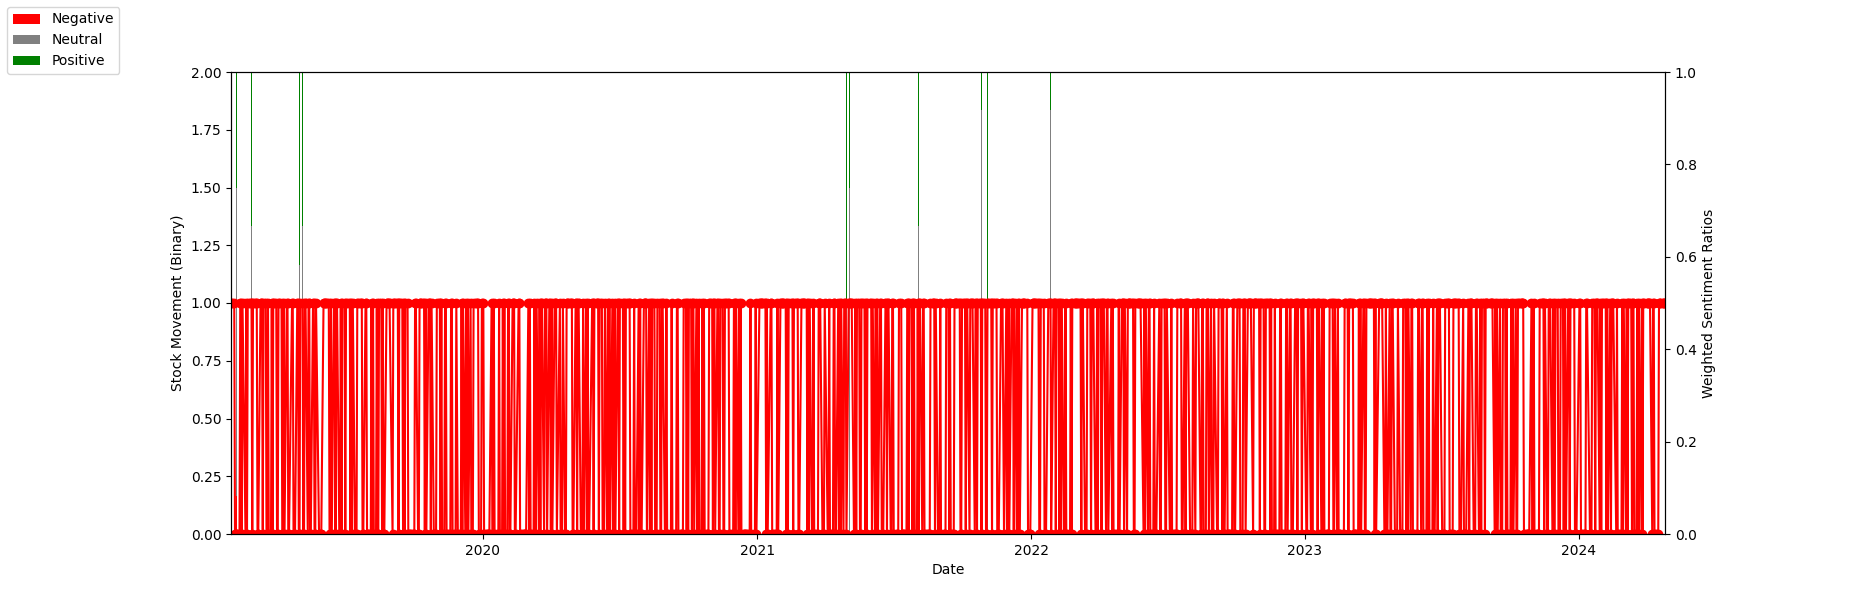

In [23]:
# Visualize Example Stock Price Movements (Up/Down) with Article Counts
%matplotlib ipympl
tz = pytz.timezone('America/New_York')

fig, ax1 = plt.subplots()
fig.set_size_inches(18.5, 6, forward=True)

tolerance = 2  # points

ret_binary = ret_df['CVX'].apply(lambda x: 1 if x > 0.0 else 0)

ax1.plot(ret_df.index, ret_binary, 'ro-', picker=tolerance)

# Calculate weighted values
dates = df_merged['Date']
weights = {
    "Negative": (df_merged['Neg_ratio_avg'] * df_merged['article_count']).tolist(),
    "Neutral": (df_merged['Neu_ratio_avg'] * df_merged['article_count']).tolist(),
    "Positive": (df_merged['Pos_ratio_avg'] * df_merged['article_count']).tolist()
}

colors = {
    "Negative": 'red',
    "Neutral": 'gray',
    "Positive": 'green'
}

ax2 = ax1.twinx()

width = 0.1
bottom = np.zeros(len(dates))

for sentiment, weight in weights.items():
    p = ax1.bar(dates, weight, width, label=sentiment, bottom=bottom, color=colors[sentiment])
    bottom += weight

ax1.set_xlim(left=ret_df.index.min(), right=ret_df.index.max())
ax2.set_xlim(left=ret_df.index.min(), right=ret_df.index.max())

# Add labels and legend
ax1.set_xlabel('Date')
ax1.set_ylabel('Stock Movement (Binary)')
ax2.set_ylabel('Weighted Sentiment Ratios')
fig.legend(loc='upper left')

plt.show()




def onclick(event):
    line = event.artist
    xdata, ydata = line.get_data()
    ind = event.ind
    datetime_obj  = xdata[ind][0].astype('datetime64[s]').astype(datetime)
    formatted_date = datetime_obj.strftime('%Y-%m-%d')
    print(formatted_date)
    #query = 'summarize the top news articles for chevron?'
    #top_results = 3
    #print(textwrap.fill(ask_vector_query(query, top_results, date=str(formatted_date), pinecone_index = "newsembedding3"), width=80))

#cid = fig.canvas.mpl_connect('button_press_event', onclick)
cid = fig.canvas.mpl_connect('pick_event', onclick)

In [24]:
# prep data for modeling
df_merged_drop = df_merged.drop(['Returns','Returns Next Day', 'Returns Next Day(no NaN)'], axis=1)
df_dropna = df_merged_drop.dropna()

# Convert the 'Date' column to datetime
df_dropna['Date'] = pd.to_datetime(df_dropna['Date'])

# Define the split date
base_date = pd.to_datetime('2020-01-01')
split_date = pd.to_datetime('2023-01-01')

# Split the DataFrame
train_df = df_dropna[(df_dropna['Date'] < split_date) & (df_dropna['Date'] >= base_date)]
test_df = df_dropna[df_dropna['Date'] >= split_date]

# define input variables
X_train_df = train_df.drop(columns=['Date','Ticker','Returns (no NaN)'])
X_test_df = test_df.drop(columns=['Date','Ticker','Returns (no NaN)'])

# define target variable
y_train_df = train_df['Returns (no NaN)'].apply(lambda x: 1 if x > 0.0 else 0)
y_test_df = test_df['Returns (no NaN)'].apply(lambda x: 1 if x > 0.0 else 0)

# Split the dataset into training and test sets
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# If you need to separate features and labels
X_train = X_train_df
y_train = y_train_df

X_test = X_test_df
y_test = y_test_df

print(len(X_train), len(y_train), len(X_test), len(y_test))

175 175 25 25


<ipython-input-24-b6d9b3253697>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_dropna['Date'] = pd.to_datetime(df_dropna['Date'])


Fitting 5 folds for each of 1 candidates, totalling 5 fits


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


{'bootstrap': True, 'max_depth': 10, 'max_features': 'auto', 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100}
Accuracy: 0.6
Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.67      0.71        18
           1       0.33      0.43      0.38         7

    accuracy                           0.60        25
   macro avg       0.54      0.55      0.54        25
weighted avg       0.63      0.60      0.61        25

Index(['article_count', 'Finance', 'Production', 'Reserves_MA', 'Regulatory',
       'Green_Energy', 'OG_Price', 'Neu_ratio_avg', 'Pos_ratio_avg',
       'Neg_ratio_avg'],
      dtype='object')
[0.03742818 0.06395281 0.10074744 0.15713146 0.06904902 0.06551235
 0.08170657 0.17492909 0.12718906 0.12235402]


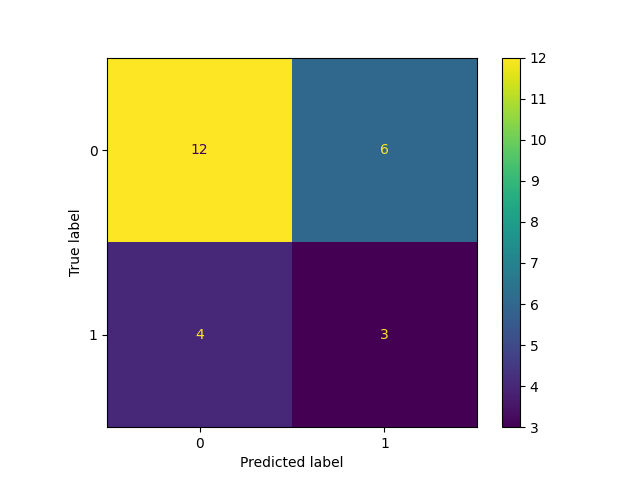

In [28]:
######## Train Random Forest Model ############

#Define the parameter grid
# param_grid = {
#    'n_estimators': [100, 200, 300],
#    'max_depth': [None, 10, 20, 30],
#    'min_samples_split': [2, 5, 10],
#    'min_samples_leaf': [1, 2, 4],
#    'max_features': ['auto', 'sqrt', 'log2'],
#    'bootstrap': [True, False]
# }
param_grid = {
    'n_estimators': [100],
    'max_depth': [10],
    'min_samples_split': [2],
    'min_samples_leaf': [4],
    'max_features': ['auto'],
    'bootstrap': [True]
} #shows best results Accuracy 0.6

# Create a Random Forest classifier
rf_clf = RandomForestClassifier(random_state=42)

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=rf_clf, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)

# Train the classifier on the training set
grid_search.fit(X_train, y_train)

# Output the best parameters
print(grid_search.best_params_)

# Use the best estimator for predictions
best_model = grid_search.best_estimator_

# Make predictions on the test set
y_pred = best_model.predict(X_test)

# Calculate the accuracy of the classifier
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")
# Print classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))
print(X_train_df.columns)
print(best_model.feature_importances_)
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(best_model, X_test, y_test)

In [32]:
from sklearn.preprocessing import LabelEncoder

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Apply label encoding to categorical columns
X_train['Reserves_MA'] = label_encoder.fit_transform(X_train['Reserves_MA'])
X_train['Green_Energy'] = label_encoder.fit_transform(X_train['Green_Energy'])

X_test['Reserves_MA'] = label_encoder.transform(X_test['Reserves_MA'])
X_test['Green_Energy'] = label_encoder.transform(X_test['Green_Energy'])


Fitting 5 folds for each of 2916 candidates, totalling 14580 fits
{'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 3, 'n_estimators': 300, 'reg_alpha': 0.1, 'reg_lambda': 1.5, 'subsample': 0.8}
Accuracy: 0.52
Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.56      0.63        18
           1       0.27      0.43      0.33         7

    accuracy                           0.52        25
   macro avg       0.49      0.49      0.48        25
weighted avg       0.59      0.52      0.54        25

[0.16013524 0.08475351 0.09369896 0.09546462 0.08559557 0.07764773
 0.10113467 0.09890669 0.09354668 0.10911627]


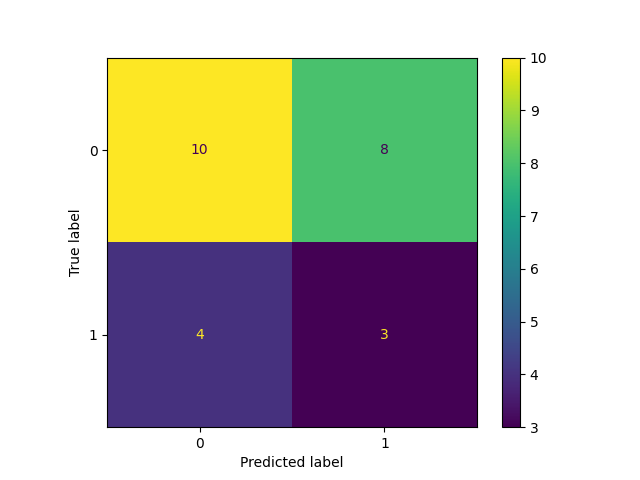

In [33]:
############# Train XGBoost Model ##############
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid = {
   'n_estimators': [100, 200, 300],
   'max_depth': [3, 6, 9],
   'learning_rate': [0.1, 0.2, 0.3],
   'subsample': [0.8, 1.0],
   'colsample_bytree': [0.8, 1.0],
   'gamma': [0, 0.1, 0.2],
   'reg_alpha': [0, 0.1, 0.5],
   'reg_lambda': [1, 1.5, 2]
}

# param_grid = {
#     'colsample_bytree': [0.8],
#     'gamma': [0.1],
#     'learning_rate': [0.2],
#     'max_depth': [6],
#     'n_estimators': [100],
#     'reg_alpha': [0],
#     'reg_lambda': [2],
#     'subsample': [0.8]
# }

# Initialize the model
XGB = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=XGB, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)

# Fit the GridSearchCV to find the best parameters (assuming you have training data `X_train` and `y_train`)
grid_search.fit(X_train, y_train)

# Output the best parameters
print(grid_search.best_params_)

# Use the best estimator for predictions
best_model_XGB = grid_search.best_estimator_

# Make predictions on the test set
y_pred = best_model_XGB.predict(X_test)

# Calculate the accuracy of the classifier
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")
# Print classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))
#print(X.columns)
print(best_model_XGB.feature_importances_)
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(best_model_XGB, X_test, y_test)

Accuracy: 0.56
Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.67      0.69        18
           1       0.25      0.29      0.27         7

    accuracy                           0.56        25
   macro avg       0.48      0.48      0.48        25
weighted avg       0.58      0.56      0.57        25



/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


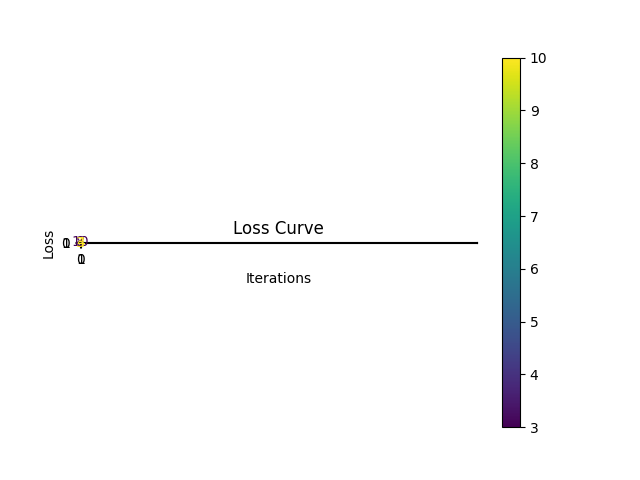

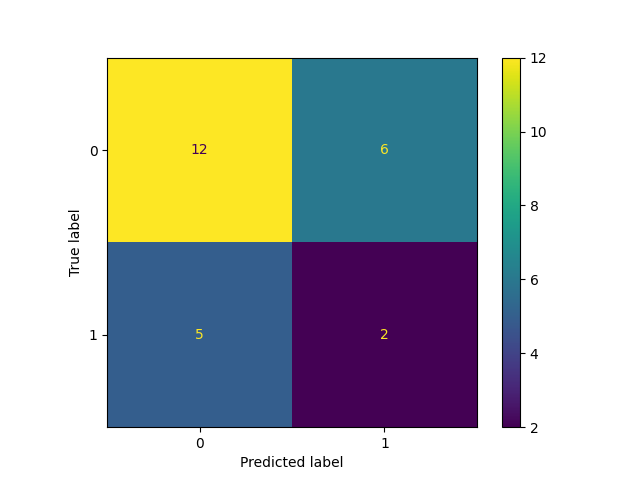

In [34]:
######## Train Simple Neural Network ##################

# Create an MLP classifier
mlp = MLPClassifier(
    hidden_layer_sizes=(100,100),
    max_iter=1000,
    solver='adam',
    random_state=42,
    learning_rate='constant',
    learning_rate_init=0.001,
    early_stopping=False,
    tol = 1e-8,
    n_iter_no_change = 100)


# Train the model
mlp.fit(X_train, y_train)

# Predict on test data
y_pred = mlp.predict(X_test)

# Calculate and print the accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Print classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Plot the loss curve
plt.plot(mlp.loss_curve_)
plt.title("Loss Curve")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.show()


ConfusionMatrixDisplay.from_estimator(mlp, X_test, y_test)

Train Accuracy: 0.5028571428571429
Test Accuracy: 0.72


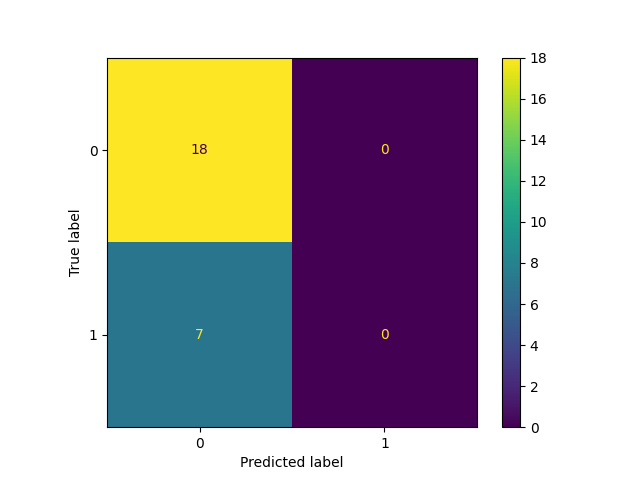

In [35]:
############# Train Support Vector Maching (SVM) #########
# Initialize lists to store training sizes and corresponding accuracies
training_sizes = np.linspace(0.1, 1.0, 10)
train_accuracies = []
test_accuracies = []

# Loop over different training set sizes
svm = SVC(kernel='sigmoid', random_state=42)
svm.fit(X_train, y_train)

# Predict on the training and test data
y_train_pred = svm.predict(X_train)
y_test_pred = svm.predict(X_test)

# Calculate accuracy for the training and test data
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

print('Train Accuracy:',train_accuracy)
print('Test Accuracy:',test_accuracy)

ConfusionMatrixDisplay.from_estimator(svm, X_test, y_test)

Earnings Calls Prompt2: SVM shows highest accuracy at 72% accuracy.


